In [244]:
import wandb
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import binarize


from models import MLP
from losses import an_full_loss, full_weighted_loss
from data.Datasets import PatchesDatasetCooccurrences
from data.PatchesProviders import MultipleRasterPatchProvider, RasterPatchProvider

In [245]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"DEVICE: {dev}\n")

DEVICE: cuda



In [246]:
run_name = '0201_MLP_env_1x1_an_full_loss_all_PA_species_with_pseudoabsences'
patch_size = 1
flatten = True
learning_rate = 1e-3
n_layers = 5
width = 1000
n_max_low_occ = 50
batch_size = 256
learning_rate = 1e-3

In [247]:
datadir = 'data/full_data/'
po_path = datadir+'Presence_only_occurrences/Presences_only_train_sampled_100_percent_min_1_occurrences.csv' 
bg_path = datadir+'Presence_only_occurrences/Pseudoabsence_locations_bioclim_soil.csv'
pa_path = datadir+'Presence_Absence_surveys/Presences_Absences_train.csv'

bioclim_dir = datadir+'EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/'
soil_dir = datadir+'EnvironmentalRasters/Soilgrids/'
landcover_dir = datadir+'EnvironmentalRasters/LandCover/LandCover_MODIS_Terra-Aqua_500m.tif'

In [248]:
p_bioclim = MultipleRasterPatchProvider(bioclim_dir, size=patch_size, flatten=flatten) 
p_soil = MultipleRasterPatchProvider(soil_dir, size=patch_size, flatten=flatten) 
p_landcover = RasterPatchProvider(landcover_dir, size=patch_size, flatten=flatten)

In [249]:
train_data = PatchesDatasetCooccurrences(occurrences=po_path, providers=(p_bioclim, p_soil, p_landcover), pseudoabsences=bg_path)
print(f"\nTRAINING DATA: n_items={len(train_data)}, n_species={len(train_data.species)}")

n_features = train_data[0][0].shape[0]
n_species = len(train_data.species)
print(f"nb of features = {n_features}")

low_occ_species = train_data.species_counts[train_data.species_counts <= n_max_low_occ].index
low_occ_species_idx = np.where(np.isin(train_data.species, low_occ_species))[0]
print(f"nb of species with less than {n_max_low_occ} occurrences = {len(low_occ_species_idx)}")

val_data = PatchesDatasetCooccurrences(occurrences=pa_path, providers=(p_bioclim, p_soil, p_landcover), species=train_data.species)
print(f"\nVALIDATION DATA: n_items={len(val_data)}, n_species={len(val_data.species)}")

nb pseudoabsences =  (2856818, 4)

TRAINING DATA: n_items=2856818, n_species=2174
nb of features = 41
nb of species with less than 50 occurrences = 468

VALIDATION DATA: n_items=7438, n_species=2174


In [252]:
species_counts = list(train_data.species_counts)

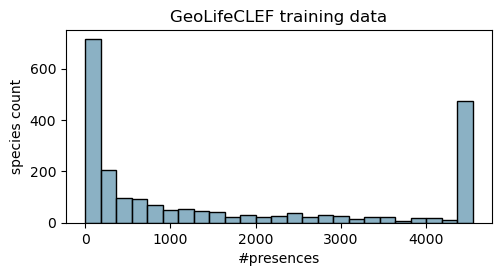

In [253]:
plt.figure(figsize=(5.5,2.5))
sns.histplot(species_counts, bins=25, color='#6497B1')
plt.ylabel("species count")
plt.xlabel("#presences")
plt.title("GeoLifeCLEF training data")
plt.savefig("species_counts_geolifeclef.pdf", bbox_inches='tight')
plt.show()

In [24]:
# train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=16)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=False, batch_size=batch_size, num_workers=4)

# model and optimizer
model = MLP(n_features, n_species, n_layers, width).to(dev)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# loss function
loss_fn = an_full_loss 
# species_weights = torch.tensor(train_data.species_weights).to(dev)
val_loss_fn = torch.nn.BCEWithLogitsLoss()

In [31]:
checkpoint = torch.load(f"models/{run_name}/last.pth")#best_val_loss.pth")
print(checkpoint['epoch'])
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print(checkpoint['val_auc'])

149
0.785647802059331


In [34]:
model.eval()
labels_list, y_pred_list = [], []

for inputs, labels in tqdm(val_loader):
    inputs = inputs.to(torch.float32).to(dev)
    labels = labels.to(torch.float32).to(dev)
    labels_list.append(labels.cpu().detach().numpy())

    y_pred = model(inputs)
    y_pred_sigmoid = torch.sigmoid(y_pred)
    y_pred_list.append(y_pred_sigmoid.cpu().detach().numpy())

labels = np.concatenate(labels_list)
y_pred = np.concatenate(y_pred_list)

100%|██████████| 30/30 [00:03<00:00,  9.88it/s]


In [39]:
roc_auc_score(labels, y_pred)

0.7856477944925715

In [40]:
roc_auc_score(labels[:, low_occ_species_idx], y_pred[:, low_occ_species_idx])

0.8021208924074779

In [183]:
df = pd.DataFrame(train_data.species_counts, columns=['n_occ']).reset_index()
df['auc'] = [roc_auc_score(labels[:,i], y_pred[:,i]) for i in range(labels.shape[1])]
df

,index,n_occ,auc
0,1,2261,0.942233
1,5,4529,0.641626
2,10,2162,0.938100
3,11,4508,0.668044
4,24,4539,0.808725
...,...,...,...
2169,10028,204,0.913114
2170,10031,20,0.799381
2171,10035,110,0.467925
2172,10038,10,0.944332


<AxesSubplot: xlabel='n_occ', ylabel='auc'>

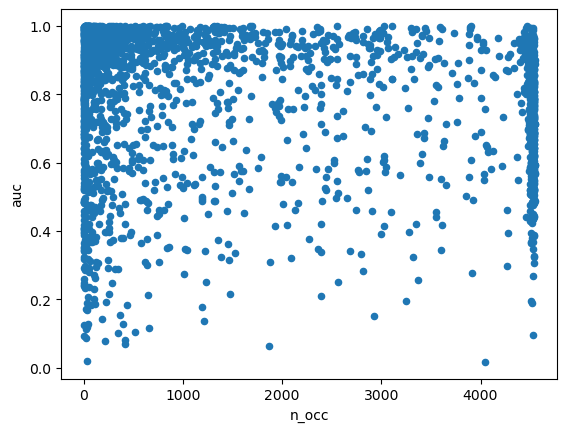

In [184]:
df.plot.scatter(x='n_occ', y='auc')

array([[<AxesSubplot: title={'center': 'auc'}>]], dtype=object)

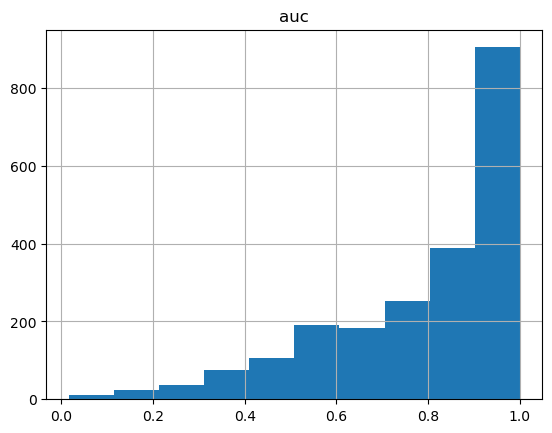

In [185]:
df.hist('auc')

In [132]:
f1_scores = {}

In [133]:
def compute_f1(labels, pred):
    tn, fp, fn, tp = confusion_matrix(labels, pred).ravel()
    f1 = tp / (tp + ((fp+fn)/2))
    return f1

In [148]:
np.arange(0.025, 1, 0.025)

array([0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  , 0.225,
       0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425, 0.45 ,
       0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 , 0.675,
       0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875, 0.9  ,
       0.925, 0.95 , 0.975])

In [141]:
for thresh in [0.725, 0.775, 0.825, 0.875]:#[0.1,0.2,0.3,0.4,0.5,0.6]:
    y_pred_bin = binarize(y_pred, threshold=thresh)
    f1_list = [compute_f1(labels[i,:], y_pred_bin[i,:]) for i in range(labels.shape[0])]
    f1_mean = np.mean(f1_list)
    print(thresh, '.... f1 = ', f1_mean)
    f1_scores[thresh] = f1_mean

0.725 .... f1 =  0.06117215804106441
0.775 .... f1 =  0.06264313190626879
0.825 .... f1 =  0.06173608953075929
0.875 .... f1 =  0.05883165026162659


In [142]:
dict(sorted(f1_scores.items()))

{0.1: 0.02710992021944885,
 0.2: 0.03364692441686345,
 0.3: 0.03942517650257939,
 0.4: 0.04484486907101754,
 0.5: 0.05034539790447907,
 0.6: 0.056212310325247414,
 0.7: 0.06004252688166328,
 0.725: 0.06117215804106441,
 0.75: 0.06217998207848221,
 0.775: 0.06264313190626879,
 0.8: 0.06277095937546352,
 0.825: 0.06173608953075929,
 0.85: 0.06166061019067241,
 0.875: 0.05883165026162659,
 0.9: 0.05529068820707533}

In [176]:
max_f1 = np.max(list(f1_scores.values()))
threshold = [k for k,v in f1_scores.items() if v == max_f1][0]
print('threshold', threshold)
print('max f1', max_f1)

threshold 0.8
max f1 0.06277095937546352


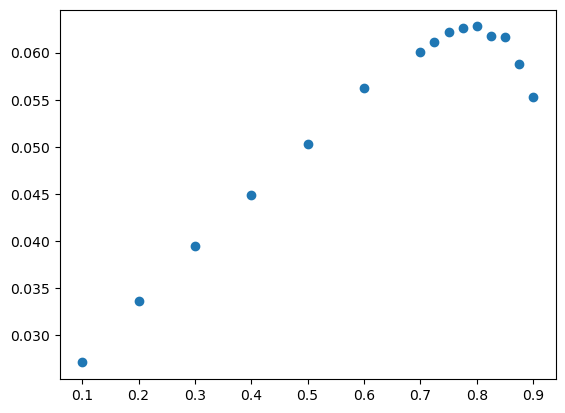

In [143]:
plt.scatter(x=f1_scores.keys(), y=f1_scores.values())

In [197]:
f1_scores

{0.1: 0.02710992021944885,
 0.2: 0.03364692441686345,
 0.3: 0.03942517650257939,
 0.4: 0.04484486907101754,
 0.5: 0.05034539790447907,
 0.6: 0.056212310325247414,
 0.7: 0.06004252688166328,
 0.8: 0.06277095937546352,
 0.9: 0.05529068820707533,
 0.75: 0.06217998207848221,
 0.85: 0.06166061019067241,
 0.725: 0.06117215804106441,
 0.775: 0.06264313190626879,
 0.825: 0.06173608953075929,
 0.875: 0.05883165026162659}

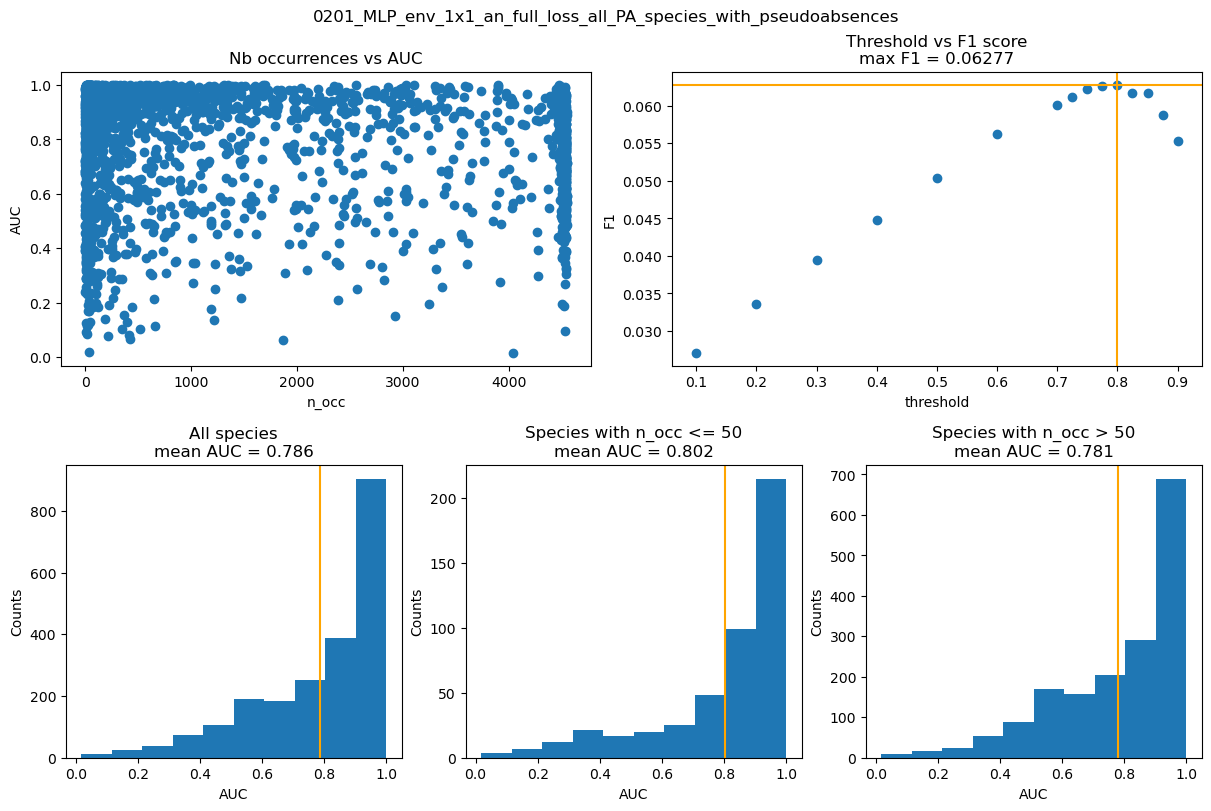

In [243]:
fig = plt.figure(layout='constrained', figsize=(12, 8))
subfigs = fig.subfigures(2, 1)

ax1, ax2 = subfigs[0].subplots(1, 2)
ax1.scatter(x=df.n_occ, y=df.auc)
ax1.set(xlabel='n_occ', ylabel='AUC', title='Nb occurrences vs AUC')

ax2.scatter(x=list(f1_scores.keys()), y=list(f1_scores.values()))
ax2.axhline(y=max_f1, color='orange')
ax2.axvline(x=threshold, color='orange')
ax2.set(xlabel='threshold', ylabel='F1', title=f"Threshold vs F1 score\nmax F1 = {max_f1:.5f}")

ax1, ax2, ax3 = subfigs[1].subplots(1, 3)
ax1.hist(df.auc)
mean1 = df.auc.mean()
ax1.axvline(mean1, color='orange')
ax1.set(xlabel='AUC', ylabel='Counts', title=f"All species\nmean AUC = {mean1:.3f}")

ax2.hist(df[df['n_occ'] <= n_max_low_occ].auc)
mean2 = df[df['n_occ'] <= n_max_low_occ].auc.mean()
ax2.axvline(mean2, color='orange')
ax2.set(xlabel='AUC', ylabel='Counts', title=f"Species with n_occ <= 50\nmean AUC = {mean2:.3f}")

ax3.hist(df[df['n_occ'] > n_max_low_occ].auc)
mean3 = df[df['n_occ'] > n_max_low_occ].auc.mean()
ax3.axvline(mean3, color='orange')
ax3.set(xlabel='AUC', ylabel='Counts', title=f"Species with n_occ > 50\nmean AUC = {mean3:.3f}")

fig.suptitle(run_name)
plt.savefig('test.png')